# Retinanet Model (FPN + Focal Loss)

Import all necessary libraries

In [0]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, Add
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Reshape
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras import backend as K

import math

Using TensorFlow backend.


## 1. Hyperparameters

<pre> num_classes              = No. of classes to predict in each image </pre>

<pre> include_top              = False: encoding outputs Or True:Only classification output (For ResNet BackBone Model) </pre>

<pre> regression_filter        = No. of filters/feature map in regression subnet (except last layer) </pre>

<pre> classification_filter    = No. of filters/feature map in classification subnet (except last layer) </pre>

<pre> pyramid_network_filters  = No. of filters/feature map in each FPN (Feature Pyramid Network) </pre>

<pre> prior_prob               = Confidence Value of each anchor boxes having foreground object at starting of training
                            (To Improve training stability )</pre>

<pre> max_detections           = Maxium number of detections per each image </pre>

<pre> score_threshold          = Used to prefilter </pre>

<pre> iou_threshold            =  Threshold to identity postive or negative detection </pre>



In [0]:
input_image_size = [None,None,3]
num_classes=20
include_top= False #False= Mutiple enconding o/p, True:classification o/p
pyramid_network_filters=256
data_format='channels_last'
regression_filter=256
classification_filter=256
prior_prob = 0.01
class_specific_filter = False 
max_detections=10
score_threshold=0.05
iou_threshold=0.5
parallel_iterations=4
learning_rate=1e-5

#Basic Anchors parameters
sizes   = np.array([32.0, 64.0, 128.0, 256.0, 512.0], K.floatx())
strides = np.array([8.0, 16.0, 32.0, 64.0, 128.0], K.floatx())
ratios  = np.array([0.5, 1, 2], K.floatx())
scales  = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], K.floatx())


In [0]:
num_anchors = len(ratios) * len(scales) #9


## 2. Resnet50 Model

Import resnet model(Only architecture)

Command:
> resnet50 = keras_resnet.models.ResNet50(Input_layer, classes=num_classes,include_top=include_top)

In [0]:
!pip install keras-resnet
import keras_resnet
import keras_resnet.models

  Running setup.py bdist_wheel for keras-resnet ... - done
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-resnet


## 3. Retinanet Model (Resnet50 as Backbone)

**Overview of Retianet Architecture**

![alt text](https://cdn-images-1.medium.com/max/1600/1*NuB7VZNmeH_VyxIF-84BXg.png)

**Figure 1. Retinanet Model Architecture**

(a) Feedforward ResNet architecture  

(b) Feature Pyramid Network (FPN)  backbone on top of this feedforward ResNet architecture to generate a rich, multi-scale convolutional feature pyramid .

    To this FPN backbone RetinaNet attaches two subnetworks, one for classifying anchor boxes and one for regressing from anchor boxes to ground-truth object boxes 

(c) Classification Subnet

(d) Regression Subnet 

##### 3.1 Feature Pyramid Network

**(b) Feature Pyramid Network Architecture**

Bottom-Up Pathway = ResNet50 layers In our case. called it {C3, C4, C5}

Top-Down Pathway and Lateral Connection = Explained in below figure

![Feature Pyramid Network](https://cdn-images-1.medium.com/max/960/1*D_EAjMnlR9v4LqHhEYZJLg.png)

Finally, a 3×3 convolution is applied on each merged map, which is to reduce the aliasing effect of upsampling.

Set of feature maps of FPN are called {P3, P4, P5}, corresponding to {C3, C4, C5} that are respectively of the same spatial sizes. Additionally P6 & P7 maps are computed by 3x3 convolution. so final set of feature maps of FPN are {P3, P4, P5, P6, P7} having same no. of channels(=256)


In [0]:
def Feature_Pyramid_Network(backbone_layers,pyramid_network_filters):
  [C3,C4,C5]=backbone_layers #(batch,height,width,channel)
  
  C3_height   = K.shape(C3)[1] 
  C3_width    = K.shape(C3)[2]
  C4_height   = K.shape(C4)[1]
  C4_width    = K.shape(C4)[2]
  
 
  P5          = Conv2D( kernel_size=1,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format) (C5)
  P5_Upscale  = keras.layers.Lambda( lambda image1: tf.image.resize_images(P5, (C4_height,C4_width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)) (P5)
  P5          = Conv2D( kernel_size=3,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format, name='P5') (P5)
  
  P4          = Conv2D( kernel_size=1,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format) (C4)
  P4          = keras.layers.Add() ([P4,P5_Upscale])
  P4_Upscale  = keras.layers.Lambda( lambda image2: tf.image.resize_images(P4, (C3_height,C3_width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)) (P4)
  P4          = Conv2D( kernel_size=3,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format, name='P4') (P4)
  
  P3          = Conv2D( kernel_size=1,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format) (C3)
  P3          = keras.layers.Add() ([P3,P4_Upscale])
  P3          = Conv2D( kernel_size=3,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format, name='P3') (P3)
  
  P6          = Conv2D( kernel_size=3,   filters=pyramid_network_filters,   strides=2,   padding='same',   data_format=data_format, name='P6') (P5)
  
  P6_relu     = Activation('relu') (P6)
  P7          = Conv2D( kernel_size=3,   filters=pyramid_network_filters,   strides=2,   padding='same',   data_format=data_format, name='P7') (P6_relu)
  
  
  return [P3, P4, P5, P6, P7]

##### 3.2 Subnet_model = Classification subset + Regression subset model

**(c) Classification Subnet**

Classification subnet find objectness score for each A anchors & K classes at each position of FPN feature maps

This is a FCN which applies four 3×3 conv layers (having C filters & ReLU) & at last apply a 3×3 conv layer having KA filters

(**K**= 20 classes, **A**= 9 anchors, and **C** = 256 filters)
<pre>  </pre>
**(d) Box Regression Subnet**

In case object detected, Box Regression subnet find offset value for each anchor boxes compare to a nearby ground-truth object

This subnet is a FCN which applies four 3×3 conv layers (having C filters & ReLU )& at last apply a 3×3 conv layer having 4A filters


In [0]:
#Classification Subnet = shape[Batch,Anchors,num_classes]
def classification(pyramid_network_filters, num_classes,classification_filter,num_anchors):
  
  bias_init =        - math.log((1 - prior_prob) / prior_prob)     #b = − log((1 − π)/π)
  
  feature_map =      Input(shape =(None,None,pyramid_network_filters))
  
  class1=            Conv2D( kernel_size=3,   filters=classification_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                           kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (feature_map)
  class2=            Conv2D( kernel_size=3,   filters=classification_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                           kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (class1)
  class3=            Conv2D( kernel_size=3,   filters=classification_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                           kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (class2)
  class4=            Conv2D( kernel_size=3,   filters=classification_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                           kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (class3)
  
  class_subnet_out= Conv2D( kernel_size=3,  filters= num_classes*num_anchors ,   strides=1,   padding='same',   data_format=data_format,
                          kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None),
                          bias_initializer= keras.initializers.Constant(value=bias_init),name='classification_output' )    (class4) 
  
  #Covert Shape=[Batch, W,H, 4*num_classes] --> [Batch,Anchors,num_classes]
  #4D to 3D shape
  class_subnet_out = Reshape((-1, num_classes), name='classification_reshape')(class_subnet_out)
  class_subnet_out = Activation('sigmoid', name='classification_sigmoid')(class_subnet_out)
  
  return keras.models.Model(inputs=feature_map, outputs=class_subnet_out, name='Classification_subnet')#[Batch,Anchors,num_classes]

In [0]:
#Box Regression Subnet = shape[Batch,Anchors,4]
def regression(pyramid_network_filters, regression_filter,num_anchors):
  feature_map=     Input(shape =(None,None,pyramid_network_filters))
  
  Reg1=            Conv2D( kernel_size=3,   filters=regression_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format, 
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (feature_map)
  Reg2=            Conv2D( kernel_size=3,   filters=regression_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (Reg1)
  Reg3=            Conv2D( kernel_size=3,   filters=regression_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (Reg2)
  Reg4=            Conv2D( kernel_size=3,   filters=regression_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (Reg3)
  
  Reg_subnet_out=  Conv2D( kernel_size=3,   filters= 4 *num_anchors ,   strides=1,   padding='same',   data_format=data_format,
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros',name='regression_output') (Reg4)
  
  #Covert Shape=[Batch, W,H, 4*num_anchors] --> [Batch,Anchors,4]
  #4D to 3D shape
  Reg_subnet_out=  Reshape((-1, 4), name='Regression_reshape') (Reg_subnet_out) 
  
  return keras.models.Model(inputs=feature_map,outputs=Reg_subnet_out,name='Regression_subnet') #[Batch,Anchors,4]
  

In [0]:
def subnet_models(pyramid_network_filters, num_classes,regression_filter,classification_filter,num_anchors):
  return ([regression(pyramid_network_filters, regression_filter,num_anchors),
       classification(pyramid_network_filters, num_classes,regression_filter,num_anchors)]
         )

#### 3.3 Retinanet Model

In [0]:
def retinanet_model(input_image_size,include_top, pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors):
  
  # Resnet50 model 
  x = keras.layers.Input(input_image_size)
  resnet50 = keras_resnet.models.ResNet50(x, classes=num_classes,include_top=include_top)
  
  backbone_layers= resnet50.outputs[1:] # backbone layers   
  
  #Feature pyramid networks with Resnet backbone (Features)
  features = Feature_Pyramid_Network(backbone_layers=backbone_layers, pyramid_network_filters=pyramid_network_filters) # Features [P3,P4,P5,P6,P7]
  
  #connect subnet to each feature pyramid layer/map
  models=subnet_models(pyramid_network_filters, num_classes,regression_filter,classification_filter,num_anchors)
  
  regression     = keras.layers.Concatenate(axis=1,name='Subnets_Regression')    ([models[0](feature) for feature in features]) #model[0] = regression_model
  classification = keras.layers.Concatenate(axis=1,name='Subnets_Classification')([models[1](feature) for feature in features]) #model[1] = classfication_model
  
  return keras.models.Model(inputs=x, outputs=[regression,classification],name='Retinanet')

## 4. Retinanet box(Wrapper of Retinanet for object detection)

**Inference Model** : To perform Object detection on image

##### 4.1 Generate Anchors: Generate anchors for each spatial location of each feature map (FPN's)

**basic_anchor**: Generate basic anchors having basic shape (based on scales & ratios)

            size: The base size of the anchors to generate
            stride: The stride of the anchors to generate
            ratios: The ratios of the anchors to generate
            scales: The scales of the anchors to generate
            
 E.g : For 3 different scales & ratios, there will be 9 different basic anchors (shown in below figure)
 
![Basic_anchors](https://cdn-images-1.medium.com/max/1600/1*IS_9HnkfDdF00nID6xxF_A.png)

In [0]:
def basic_anchor(size,ratios,scales,num_anchors):
  # Generate basic anchors(=num_anchors) based on ratio+scales for each SIZE
  
  #scaled height & Width
  scaled_size= np.array([size * scale for scale in scales])
  
  heights = scaled_size
  widths  = scaled_size
  
  
  #Apply ratio on H & W  
  heights = np.array( [ heights*np.sqrt(ratio)   for ratio in ratios] ) # H = H * 1/sqrt(ratio)
  widths = np.array( [  widths*np.sqrt(1/ratio)  for ratio in ratios] )  # W = W * sqrt(ratio)
   
  
  heights= np.reshape(heights,(num_anchors) ) #shape=(num_anchors,)
  widths = np.reshape(widths, (num_anchors) )
  # convert (x,y,h,w) to (x1,y1,x2,y2)  
  x1= -(widths)/2
  x2= widths/2
  y1= -(heights)/2
  y2= heights/2
  
  basic_anchors=np.transpose(np.array([x1,y1,x2,y2]))   # (4,num_anchors)-->(num_anchors,4)
  return basic_anchors #(x1,y1,x2,y2) , shape=(num_anchors,4) 
  
  

**shifted_anchor:** Produce anchors for each spatial location of given feature map, based on shape of the feature map and stride size for given basic_anchor

In [0]:
def shifted_anchor(basic_anchors,num_anchors,feature,stride):  
  
  import tensorflow
  
  height_feature = feature[0]
  width_feature  = feature[1]
  
   
  shift_y = (K.arange(0, height_feature, dtype=K.floatx()) + K.constant(0.5, dtype=K.floatx())) * stride
  shift_x = (K.arange(0, width_feature,  dtype=K.floatx()) + K.constant(0.5, dtype=K.floatx())) * stride

  shift_x, shift_y = meshgrid(shift_x, shift_y) # shape=(W_f , H_f)  #Check
  shift_x = K.reshape(shift_x, [-1]) # shape= W_f * H_f  
  shift_y = K.reshape(shift_y, [-1]) 
  
 
  shifts = K.stack([shift_x,shift_y,shift_x,shift_y], axis=0)   #packed along axis=0 , shape=[4, W_f * H_f ]

  shifts            = K.transpose(shifts) #shape=[ W_f * H_f  ,4 ]

  pixel_num = K.shape(shifts)[0]  # Total pixel ,K = W_f * H_f
  
  #Objective apply basic anchors on each pixel/point of feature map
  # [1,9,4] + [pixel,1,4] -> [pixel_num ,9,4] -> [pixel_num *9,4]   assuming 9=No. of basic anchors             
  shifted_anchor = K.reshape(basic_anchors, [1, num_anchors, 4]) + K.cast(K.reshape(shifts, [pixel_num, 1, 4]), K.floatx())
  shifted_anchor = K.reshape(shifted_anchor, [pixel_num * num_anchors, 4])
  
 
  return shifted_anchor # shape = [pixel_num *9,4]

**generate_anchors** : For each feature_map, Generate shifted_anchor/Final set of anchors

In [0]:
class feature_anchors(keras.layers.Layer):
  def __init__(self, size, stride, ratios=None, scales=None,*args,**kwargs):
    self.size   = size
    self.stride = stride
    self.ratios = ratios
    self.scales = scales
    self.num_anchors = len(ratios) * len(scales)
    self.anchors     = keras.backend.variable(basic_anchor(
        size=size,
        ratios=ratios,
        scales=scales,
        num_anchors=num_anchors,
    ))
    super(feature_anchors, self).__init__(*args, **kwargs)
    
  def call(self, inputs,**kwargs):
    feature = inputs
    feature_shape = keras.backend.shape(feature)
    shifted_anchors = shifted_anchor(self.anchors,num_anchors,feature_shape[1:3], self.stride) #shape = [pixel_num *9,4] = [shifted_anchor,4 ]   9=basic anchors
    shifted_anchors = K.tile(K.expand_dims(shifted_anchors, axis=0), (feature_shape[0], 1, 1))# Add Batch_size factor
    return shifted_anchors
  
  def compute_output_shape(self, input_shape):
    if None not in input_shape[1:]:
      total = np.prod(input_shape[1:3]) * self.num_anchors        

      return (input_shape[0], total, 4)
    else:
      return (input_shape[0], None, 4)
    

    

def generate_anchors(features,sizes,strides,ratios,scales,num_anchors):
  anchors= [feature_anchors(sizes[i],strides[i],ratios,scales,name='anchors_{}'.format(i)) (feature) for i,feature in enumerate (features) ] #shape=[batch,feature_num,shited_anchors,4]
  return keras.layers.Concatenate(axis=1, name='anchors')(anchors) #shape=[batch, feature_num*shited_anchors ,4] = [batch, Anchors, 4]
  

##### 4.2 Regression & Clip Boxes

**regressionbox** : Apply regression values to every boxes. 

It takes retinanet regression subnet outputs(offset o/p values with respect to anchor) as input. **regressionbox** basically converts these detla/offset values to absolute location (x1, y1, x2, y2)

**clipbox** : cropped/clipped box values to lie inside a given shape

In [0]:
class regressionbox(keras.layers.Layer):
  
  def compute_output_shape(self, input_shape):
    return input_shape[0]
  
  def call(self,inputs):
    anchors=inputs[0]
    deltas=inputs[1]
    
    mean = [0, 0, 0, 0]
    std = [0.2, 0.2, 0.2, 0.2]
  
    #deltas factor of width & height  
    width = anchors[:,:,2] - anchors[:,:,0]  # W = x2 - x1
    height= anchors[:,:,3] - anchors[:,:,1]  # H = y2 - y1
  
    # 'Tensor' object does not support item assignment, So build list & stack
  
    #shape(batch,Anchors)
    x1=anchors[:,:,0] + width  * (deltas[:,:,0] * std[0] + mean[0]) #denormalized deltas bcz of generator logic,we get normalized detla as input here 
    y1=anchors[:,:,1] + height * (deltas[:,:,1] * std[1] + mean[1])
    x2=anchors[:,:,2] + width  * (deltas[:,:,2] * std[2] + mean[2])
    y2=anchors[:,:,3] + height * (deltas[:,:,3] * std[3] + mean[3])
  
    predicted_boxes = K.stack([x1,y1,x2,y2],axis=2) #shape=(batch,Anchors,4)  
     
    return predicted_boxes



class clipbox(keras.layers.Layer): #clipped box/pixel value which is lying outside input image
  def compute_output_shape(self, input_shape):
    return input_shape[1]
    
  def call(self,inputs):
    boxes=inputs[0]
    image=inputs[1]
    
    image_shape= K.cast(K.shape(image), K.floatx())
    height_max = image_shape[0]
    width_max  = image_shape[1]
      
    #shape(batch,Anchors)
    x1 = clip_by_value(boxes[:, :, 0], clip_value_min=0, clip_value_max=width_max ) 
    y1 = clip_by_value(boxes[:, :, 1], clip_value_min=0, clip_value_max=height_max)
    x2 = clip_by_value(boxes[:, :, 2], clip_value_min=0, clip_value_max=width_max )
    y2 = clip_by_value(boxes[:, :, 3], clip_value_min=0, clip_value_max=height_max)
      
    predicated_cliped_boxes= K.stack([x1,y1,x2,y2],axis=2) #shape=(batch,Anchors,4) 
          
    return predicated_cliped_boxes

##### 4.3 Filter Detection

Filter Detection using classification & boxes/ regression values
1. nms_n_score_threshold: Apply non_max_suppression & score_threshold=0.05 as part of prefilter
2. detections_logic :  Select top_k detection output (defined by max_detection)
3. filter_detection: Calculate [boxes, scores, labels] using detections_logic for each batch

In [0]:
def nms_n_score_threshold(boxes, scores, labels, max_detections, score_threshold, iou_threshold):
  #Return indices contain indexes of Anchors after score_threshold+NMS
  
   
  #Apply score_threshold + nms
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  indices = where(K.greater(scores,score_threshold))#Check #shape=[X,1], X=Not fixed=Reduced_anchors; give index value for (scores>threshold) e.g. [[1][2][3]]  X=True elements
  
  filtered_boxes=gather_nd(boxes,indices)#Check #shape=[X,4]        # Reason to use gather_nd:-If we use gather here shape[X,1,4]
  filtered_scores=K.gather(scores,indices)[:,0]#shape=[X,1] --> [X]  #Reduced_anchors=Anchors whoes score > score_threshold
  
  #nms: shape=[M] ; M=Seleted Anchores/Tensors (M <= max_output_size) #Check
  nms_indices=non_max_suppression(boxes=filtered_boxes, scores=filtered_scores, max_output_size=max_detections, iou_threshold=iou_threshold) #e.g. o/p=[1 10 3]
  
  indices = K.gather(indices,nms_indices) #[M,1]
  labels = gather_nd(labels, indices) #[M] 
  indices_labels = K.stack([indices[:, 0], labels], axis=1)#shape=[M,2]
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  return indices_labels 

In [0]:
def detections_logic(boxes,classification):
    
  #~~~~~~~~~nms/score_threshold based on per class based or best scoring class
  if class_specific_filter: #classification=[Anchors,num_class]
        all_indices = []
        # perform per class filtering
        for c in range(int(classification.shape[1])):
            scores = classification[:, c] #shape=[some_anchors]
            labels = c * backend.ones((keras.backend.shape(scores)[0],), dtype='int64') #shape=[some_anchors]
            all_indices.append(nms_n_score_threshold(boxes, scores, labels,max_detections,score_threshold,iou_threshold))

        # concatenate indices to single tensor
        indices_labels = k.concatenate(all_indices, axis=0)#[X,2] X>M
  else:
    scores        = K.max   (classification,axis=1) #shape=[some_anchors]
    labels        = K.argmax(classification,axis=1) #shape=[some_anchors]
    indices_labels= nms_n_score_threshold(boxes, scores, labels,max_detections,score_threshold,iou_threshold) #shape=[M,1]
    
    
    # Select Top k(max_detection)
    labels              = indices_labels[:, 1] #[X] or [M]
    scores   = gather_nd(classification, indices_labels)#Check#[X] or [M]   #shape=[X] for class_specific_filter=TRUE
                                                                         #shape=[M] for class_specific_filter=FALSE
      
    scores_k, top_indices = top_k(input=scores, k=K.minimum(max_detections, K.shape(scores)[0]))#Check #score=Rank 1, k= Rank 0  Tensor; top_k return value+indices
    #scores/top_indices = shape[k]
    
    # filter input using the final set of indices
    
    indices_k             = K.gather(indices_labels[:, 0], top_indices)#[K]
    boxes_k               = K.gather(boxes, indices_k)  #[K,4]   Where K <= Max_detection
    labels_k              = K.gather(labels, top_indices) #[K]
    
    # Zero pad at last rows
    pad_size = K.maximum(0, max_detections - K.shape(scores)[0])#PaddingSize= 0 or max_detection-K
    boxes    = pad(boxes_k, [[0, pad_size], [0, 0]], constant_values=-1) #shape[max_detections,4] #Check
    scores   = pad(scores_k, [[0, pad_size]], constant_values=-1) #shape[max_detections]
    labels   = pad(labels_k, [[0, pad_size]], constant_values=-1) #shape[max_detections]
    
    #Verify dtype
    labels   = K.cast(labels, 'int32')
    boxes    = K.cast(boxes, K.floatx())
    scores   = K.cast(scores,K.floatx())
    
    #Verify Shape
    boxes.set_shape([max_detections, 4])
    scores.set_shape([max_detections])
    labels.set_shape([max_detections])
    
    return [boxes, scores, labels]

In [0]:
class filter_detection(keras.layers.Layer):  
   
  def call(self,inputs):
    boxes          = inputs[0]
    classification = inputs[1]
    
    def _detections_logic(args):
      boxes          = args[0]
      classification = args[1]
      return detections_logic( boxes, classification )
    
    
    outputs = map_fn(_detections_logic,elems=[boxes,classification],
                      dtype=[K.floatx(), K.floatx(),'int32'],
                      parallel_iterations=parallel_iterations )   #dtype have 3 types for outputs of detections_logic ([boxes, scores, labels])
 
    return outputs

  def compute_output_shape(self, input_shape):
    return [
        (input_shape[0][0], max_detections, 4),
        (input_shape[1][0], max_detections),
        (input_shape[1][0], max_detections)
    ] 

In [0]:
import tensorflow
def map_fn(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/map_fn .
    """
    return tensorflow.map_fn(*args, **kwargs)

def ones(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/ones .
    """
    return tensorflow.ones(*args, **kwargs)


def transpose(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/transpose .
    """
    return tensorflow.transpose(*args, **kwargs)


def map_fn(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/map_fn .
    """
    return tensorflow.map_fn(*args, **kwargs)


def pad(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/pad .
    """
    return tensorflow.pad(*args, **kwargs)


def top_k(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/nn/top_k .
    """
    return tensorflow.nn.top_k(*args, **kwargs)


def clip_by_value(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/clip_by_value .
    """
    return tensorflow.clip_by_value(*args, **kwargs)


def non_max_suppression(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/image/non_max_suppression .
    """
    return tensorflow.image.non_max_suppression(*args, **kwargs)


def range(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/range .
    """
    return tensorflow.range(*args, **kwargs)


def scatter_nd(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/scatter_nd .
    """
    return tensorflow.scatter_nd(*args, **kwargs)


def gather_nd(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/gather_nd .
    """
    return tensorflow.gather_nd(*args, **kwargs)


def meshgrid(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/meshgrid .
    """
    return tensorflow.meshgrid(*args, **kwargs)


def where(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/where .
    """
    return tensorflow.where(*args, **kwargs)

### 4.4 Retinanet_Box

**Inference Model** : During Testing/Executing , We use this inference model to perform object detection on image

*Return*: Top_k detections with following values, which is used during inference model

[Boxes,  labels , scores ]   Where, Boxes in term of (x1,y1,x2,y2)

In [0]:
def retinanet_box(model,input_image_size,include_top, pyramid_network_filters,num_classes,
                  regression_filter,classification_filter,num_anchors,sizes,ratios,scales,strides,
                 class_specific_filter, max_detections,score_threshold,iou_threshold,parallel_iterations):
  if model is None:
    model = retinanet_model(input_image_size,include_top, pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors)
  
  
  features = [model.get_layer(name=map).output for map in ['P3','P4','P5','P6','P7'] ]  #Pyramid feature map
  
  anchors = generate_anchors(features,sizes,strides,ratios,scales,num_anchors) #[batch, Anchors, 4]; Entire anchors for all batch_images, all features, all pixels
 
  #Model output 
  regression    =model.outputs[0]   #Regression output= Return deltas factor of W(for x1,x2) , H(for y1,y2); Shape=[batch,Anchors,4]
  classification=model.outputs[1]   #shape=[batch,Anchors,num_classes]
  
  #Apply regression & clipped Anchors
  boxes=regressionbox(name='regression_boxes')([anchors,regression]) #shape of anchors/regression = [batch,Anchors,4] 
  boxes=clipbox(name='boxes')([boxes,model.inputs[0]])    #model.input[0]=input/image shape=[W,H,3],  shape=[batch,Anchors,4]
  
  
  #Detection
  detections = (filter_detection(name='filter_detection')([boxes,classification]))
  
  return keras.models.Model(inputs=model.inputs, outputs=detections, name='retinanet_box')
  

## 5. Loss Function

#### 5.1 Focal Loss: Classification Loss

Focal Loss resolve class imbalance problem in RetinNet

*   Down-weight easy example & focus more on hard example using γ factor
*   α balances the importance of positive/negative examples

FL = -α \* (1-p) ^γ \*  log (p)   if y=1

FL = -(1-α) \* p^γ \*   log(1-p)  if y=0


Y | alpha | focal weight
--- | ---
0| (1-α) | p^γ
1| α | (1-p) ^γ

In [0]:
def focal(alpha=0.25, gamma=2.0):
  
    def _focal(y_true, y_pred):
      
        
        # y_true Shape=(B, N, num_classes+1)  Generator logic add exrtra 1 bit in num_class for ignore anchor
        # y_pred Shape=(B, N, num_classes)
        
        
        labels         = y_true[:, :, :-1]
        anchor_state   = y_true[:, :, -1]  # -1 for ignore, 0 for background, 1 for object
        classification = y_pred

        # Remove "ignore" anchors
        indices        = where(K.not_equal(anchor_state, -1))
        y_true         = gather_nd(labels, indices)
        y_pred         = gather_nd(classification, indices)
        
        #No. of positive anchors & Normalization logic
        Positive_anchors = where(K.equal(anchor_state, 1)) 
        Num_Positive_anchors = K.cast(K.shape(Positive_anchors)[0], K.floatx())     
        normalizer = K.maximum(K.cast_to_floatx(1.0), Num_Positive_anchors)
        
        #~~~~~~~~~~~~~~~~~~~~~~Focal Loss~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        pt_1 = where(K.equal(y_true, 1), y_pred, K.ones_like(y_pred))
        pt_0 = where(K.equal(y_true, 0), y_pred, K.zeros_like(y_pred))
        
        # Prevent Focal loss from exploide to Inf or NAN due to log (0)
        Cliped_value = 0.00001        
        pt_1 = K.clip(pt_1, Cliped_value, 1.0 - Cliped_value)
        pt_0 = K.clip(pt_0, Cliped_value, 1.0 - Cliped_value)
        
        #Compute Loss
        cls_loss = -K.sum(alpha * K.pow(1.0 - pt_1, gamma) * K.log(pt_1)) - K.sum((1.0 - alpha) * K.pow(pt_0, gamma) * K.log(1.0 - pt_0))
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        return (cls_loss / normalizer)

    return _focal

#### 5.2 Smooth L1 loss: Regression Loss


f(x) = 0.5  \* Delta \*  (x)^2         , if |x| <  (1 / Delta)

    = |x| - 0.5 / Delta   otherwise
     
Where,    
x = Y_true - Y_pred

Delta =  Sigma ** 2

Sigma = Argument defines the point where the loss changes from L2 to L1

In [0]:
def smooth_l1(sigma=3.0):
  
    def _smooth_l1(y_true, y_pred):
        
        # y_true Shape=(B, N, 5)  Generator logic add exrtra 1 bit for ignore anchor
        # y_pred Shape=(B, N, 4)
        
        
        regression_true         = y_true[:, :, :-1]
        anchor_state            = y_true[:, :, -1]  # -1 for ignore, 0 for background, 1 for object
        regression_pred         = y_pred

        # only object detected anchors
        indices         = where(K.equal(anchor_state, 1)) #Positive anchors only
        y_true          = gather_nd(regression_true, indices)
        y_pred          = gather_nd(regression_pred, indices)
        
        #No. of positive anchors & Normalization logic
        Num_Positive_anchors = K.cast(K.shape(indices)[0], K.floatx())  
        Num_Positive_anchors = K.maximum(1.0,Num_Positive_anchors)
        normalizer           = K.cast(Num_Positive_anchors, dtype=K.floatx())      
        
        
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~smooth L1 loss~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        delta = sigma ** 2
        x = K.abs(y_true - y_pred)
        regloss = where(K.less(x, 1.0 / delta),   0.5 * delta * K.pow(x, 2),   x - 0.5 / delta )
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        return K.sum(regloss) / normalizer

    return _smooth_l1

## 6. Import libraries for Pascal VOC2007 Dataset

In [0]:
!git clone https://github.com/LastSamurai333/keras-retinanet.git


In [0]:
cd keras-retinanet/

/content/keras-retinanet


In [0]:
!python3.6 -m pip install .
!python3.6 setup.py build_ext --inplace
from keras_retinanet.preprocessing.pascal_voc import PascalVocGenerator


In [0]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
  

In [0]:
!tar -xvf VOCtrainval_06-Nov-2007.tar

In [0]:
train_generator       = PascalVocGenerator('./VOCdevkit/VOC2007/','trainval') #Pascal VOC TrainVal Dataset

In [0]:
!rm VOCtrainval_06-Nov-2007.tar

## 7. Training  Model

Start training retinanet_model

In [0]:
Training_model = retinanet_model(input_image_size,include_top, pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors)
loss={
        'Subnets_Regression'    : smooth_l1(),
        'Subnets_Classification': focal()
    }

optimizer=keras.optimizers.adam(lr=learning_rate)

# compile model
Training_model.compile(optimizer,loss=loss)

In [0]:
Training_model.fit_generator(generator=train_generator, epochs=50, shuffle=True, verbose=1)

Epoch 1/4
2506/2506 [==============================] - 5752s 2s/step - loss: 525.4977 - Subnets_Regression_loss: 3.4376 - Subnets_Classification_loss: 522.0601
Epoch 2/4
2506/2506 [==============================] - 3929s 2s/step - loss: 3.4781 - Subnets_Regression_loss: 2.5081 - Subnets_Classification_loss: 0.9700
Epoch 3/4
2506/2506 [==============================] - 3926s 2s/step - loss: 3.2774 - Subnets_Regression_loss: 2.4491 - Subnets_Classification_loss: 0.8283
Epoch 4/4
2506/2506 [==============================] - 3922s 2s/step - loss: 3.1783 - Subnets_Regression_loss: 2.3807 - Subnets_Classification_loss: 0.7976


In [0]:
Training_model.save_weights("retinanet_weights.h5")
print("Saved weights to disk")

from google.colab import files
files.download('retinanet_weights.h5')

Saved weights to disk


## 8. Object Detection with Demo

Predict Object detection on image using inference model(retinanet_box)

#### 8.1 Prediction Model

In [0]:
prediction_model = retinanet_box(Training_model,input_image_size,include_top, pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors,sizes,ratios,scales,strides,
                 class_specific_filter, max_detections,score_threshold,iou_threshold,parallel_iterations)

#### 8.2 Object Detection Demo

In [0]:
!cp VOCdevkit/VOC2007/JPEGImages/000012.jpg .


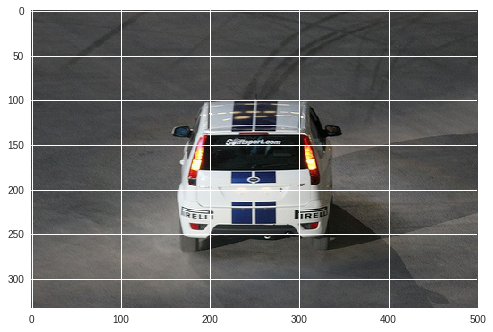

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import cv2
import os
labels_to_names = {0: 'aeroplane',1: 'bicycle',2: 'bird',3: 'boat',4:'bottle',5:'bus',6:'car',7:'cat',8:'chair',
                   9:'cow',10:'diningtable',11: 'dog',12:'horse',13:'motorbike',14:'person',15:'pottedplant',
                   16:'sheep',17:'sofa',18:'train',19:'tvmonitor'}
image=mpimg.imread('000012.jpg')
imgplot = plt.imshow(image) #show 000012.jpg Image
plt.show()

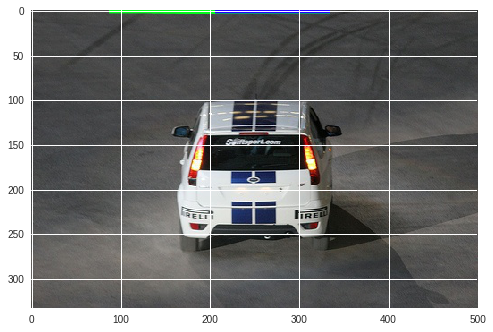

In [0]:
# Object Detection Logic

boxes, scores, labels = prediction_model.predict_on_batch(np.expand_dims(image, axis=0))

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    thickness=2
    cv2.rectangle(image, (b[0], b[1]), (b[2], b[3]), color, thickness, cv2.LINE_AA)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)
    
plt.imshow(image)
plt.show()

#####TestCase of well trained Retinanet Model

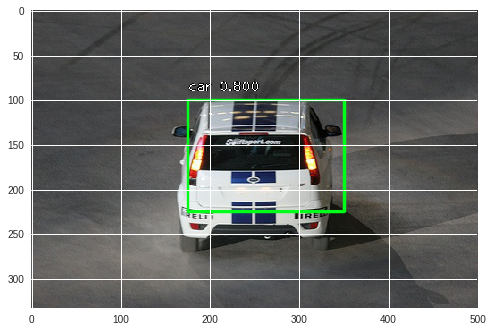

In [0]:
#Boxes,scores,labels will be more accurate after training retinanet model for more epochs
box_t=np.array([175,100,350,225])
score_t=0.80
label_t=6
color_t = label_color(label_t)
    
b_t = box_t.astype(int)
thickness=2
cv2.rectangle(image, (b_t[0], b_t[1]), (b_t[2], b_t[3]), color_t, thickness, cv2.LINE_AA)
    
caption = "{} {:.3f}".format(labels_to_names[label_t], score_t)
draw_caption(image, b_t, caption)
    
plt.imshow(image)
plt.show()
